# Laboratory work 14
##  Vehicle tracking based on GPS and odometry data fusion
## Group 1: Viktor Liviniuk, Alina Liviniuk
## Skoltech
## 2017

The objective of this laboratory work is to develop a tracking filter to estimate a vehicle’s dynamic state by assimilating the navigation data coming from different sources. The task includes the fusion of GPS data (absolute positioning) and wheel odometry data (relative positioning). Important outcome of this exercise is getting skill to solve the most fundamental data fusion tasks for intelligent traffic applications. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Part I. Assimilation of GPS data only (absolute positioning) 

Generate a true trajectory of a moving vehicle and it's measurements

In [2]:
theta = np.loadtxt('theta.txt')

In [3]:
def generate_trajectory(N, T, x0, y0, V0, theta, sigma_a):
    ax = np.random.normal(0, sigma_a, N)
    ay = np.random.normal(0, sigma_a, N)
    Vx = np.zeros(N)
    V = np.zeros(N)
    Vy = np.zeros(N)
    x = np.zeros(N)
    y = np.zeros(N)
    x[0] = x0
    y[0] = y0
    Vx[0] = V0 * np.cos(theta[0])
    Vy[0] = V0 * np.cos(theta[0])
    V[0] = V0
    for i in range(1,N):
        Vx[i] = V[i-1] * np.cos(theta[i-1]) #+ ax[i-1]*T
        Vy[i] = V[i-1] * np.sin(theta[i-1]) #+ ay[i-1]*T
        V[i] = V0 #= (Vx[i]**2 + Vy[i]**2)**.5
        x[i] = x[i-1] + Vx[i-1]*T + ax[i-1]*T**2/2
        y[i] = y[i-1] + Vy[i-1]*T + ay[i-1]*T**2/2
    return [x,y]

In [4]:
N = 500
T = .05
x0 = y0 = 0
V0 = 10
sigma_a = 1

In [5]:
[x,y] = generate_trajectory(N, T, x0, y0, V0, theta, sigma_a)

In [6]:
# Create time list
time = T * np.array(range(N))

In [7]:
def generate_measurements(x, y, sigma_eta_x, sigma_eta_y):
    zx = x + np.random.normal(0, sigma_eta_x, N)
    zy = y + np.random.normal(0, sigma_eta_y, N)
    return [zx, zy]

In [8]:
sigma_eta_x = 3
sigma_eta_y = 3
[zx, zy] = generate_measurements(x, y, sigma_eta_x, sigma_eta_y)

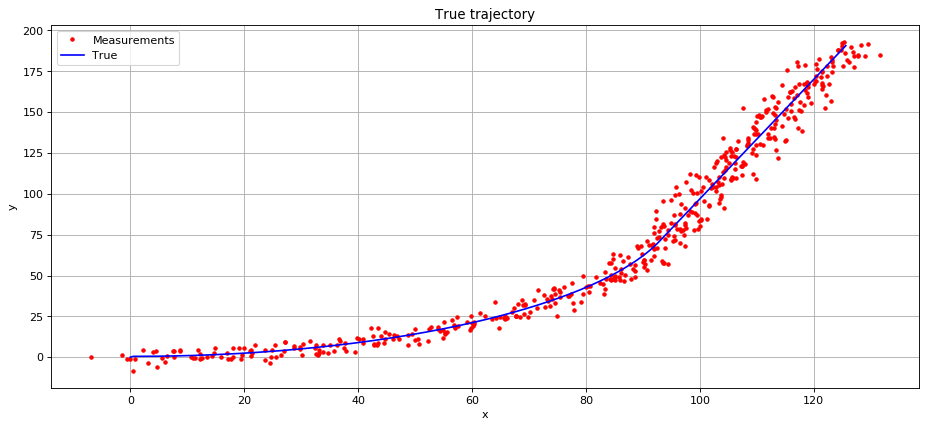

In [9]:
# Plot
plt.figure(figsize=(14, 6), dpi=80)
plt.plot(zx, zy, "r.", label='Measurements')
plt.plot(x, y, "b-", label='True')
plt.title('True trajectory')
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

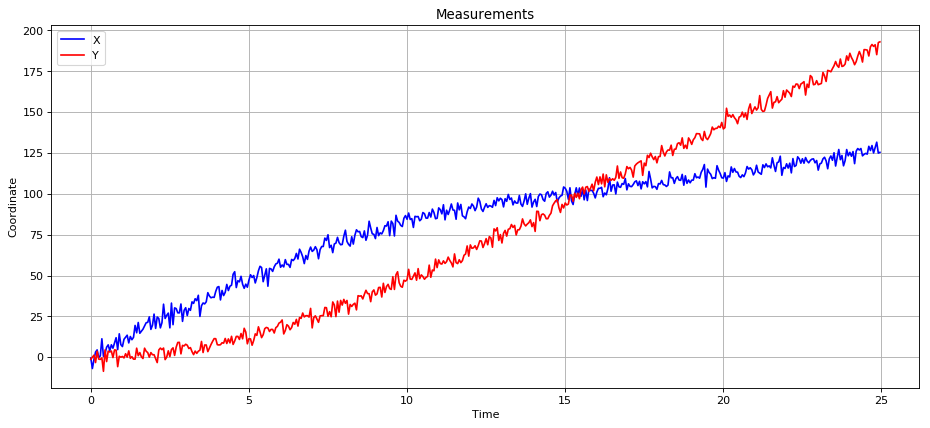

In [10]:
# Plot
plt.figure(figsize=(14, 6), dpi=80)
plt.plot(time, zx, "b-", label='X')
plt.plot(time, zy, "r-", label='Y')
plt.title('Measurements')
plt.grid()
plt.xlabel('Time')
plt.ylabel('Coordinate')
plt.legend()
plt.show()

### Kalman Filter

In [11]:
F = np.array([[1, T, 0, 0], [0, 1, 0, 0], [0, 0, 1, T], [0, 0, 0, 1]])
G = np.array([[T**2/2, 0], [T, 0], [0, T**2/2], [0, T]])

The dependencies 𝑉𝑥=𝑉𝑖−1cos (Θi−1)𝑇 and 𝑉𝑦=𝑉𝑖−1sin (Θi−1)𝑇 are approximate and describe immediate values of 𝑉𝑥 and 𝑉𝑦.  Angle Θ may change at step from 𝑖−1 to step 𝑖. 
Therefore we should increase the covariance matrix of state noise, that will result in a greater filter gain 𝐾, and thus more confidence to measurements. In other words, by increasing 𝜎𝑎2 we compensate the imperfections of the motion model.  

In [12]:
sigma_a_increased = 5
Q = np.matmul(G, G.transpose()) * sigma_a_increased**2

In [13]:
# Kalman Filter
def KalmanFilter(zx, zy, T, Xf0, P00, R, F, Q, H):
    N = zx.size
    z = np.array([zx, zy])
    Xp = np.zeros((4,N))
    Xp[:,0] = Xf0[:,0]
    Xf = np.zeros((4,N))
    Xf[:,0] = Xf0[:,0]
    Ht = np.transpose(H)
    Ft = np.transpose(F)
    I = np.eye(4)
    K = np.zeros((4,2,N))
    Pp = np.zeros((4,4,N))
    Pp[:,:,0] = P00
    Pf = np.zeros((4,4,N))
    Pf[:,:,0] = P00
    for i in range(1, N):
        # prediction
        Xp[:,i] = np.matmul(F, Xf[:,i-1])
        Pp[:,:,i] = np.matmul(np.matmul(F, Pf[:,:,i-1]), Ft) + Q
        # filtration
        K[:,:,i] = np.matmul(Pp[:,:,i], np.matmul(Ht, np.linalg.inv(np.matmul(np.matmul(H, Pp[:,:,i]), Ht) + R)))
        Xf[:,i] = Xp[:,i] + np.matmul(K[:,:,i], (z[:,i] - np.matmul(H, Xp[:,i])))
        Pf[:,:,i] = np.matmul(I - np.matmul(K[:,:,i], H), Pp[:,:,i])
    return [Xf, Xp, Pf, Pp];

In [14]:
#initial conditions
X0 = np.array([[zx[1]], [(zx[1]-zx[0])/T], [zy[1]], [(zy[1]-zy[0])/T]])
P00 = np.eye(4) * 10**4;
R = np.array([[sigma_eta_x**2, 0], [0, sigma_eta_y**2]])
H = np.array([[1,0,0,0],[0,0,1,0]])

In [15]:
[Xf, Xp, Pf, Pp] = KalmanFilter(zx, zy, T, X0, P00, R, F, Q, H)

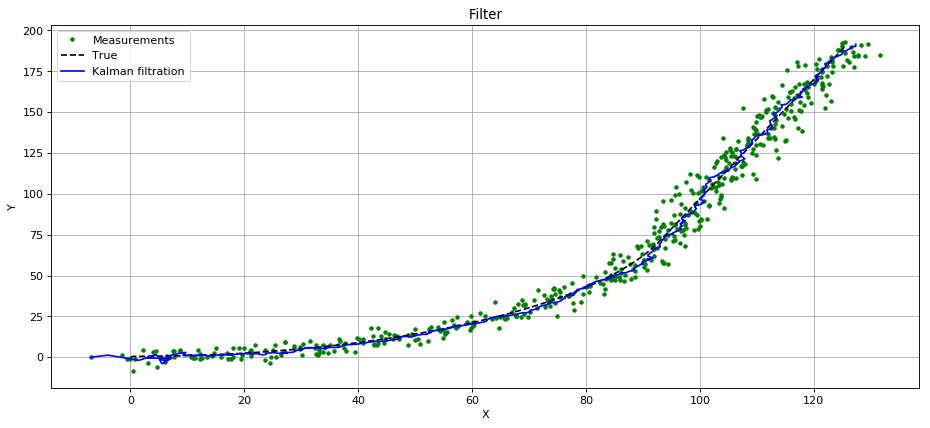

In [16]:
# Plot Kalman
plt.figure(figsize=(14, 6), dpi=80)
plt.plot(zx, zy, "g.", label='Measurements')
plt.plot(x, y, "k--", label='True')
plt.plot(Xf[0], Xf[2], 'b-', label = "Kalman filtration")

plt.grid()
plt.legend()
plt.title('Filter')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

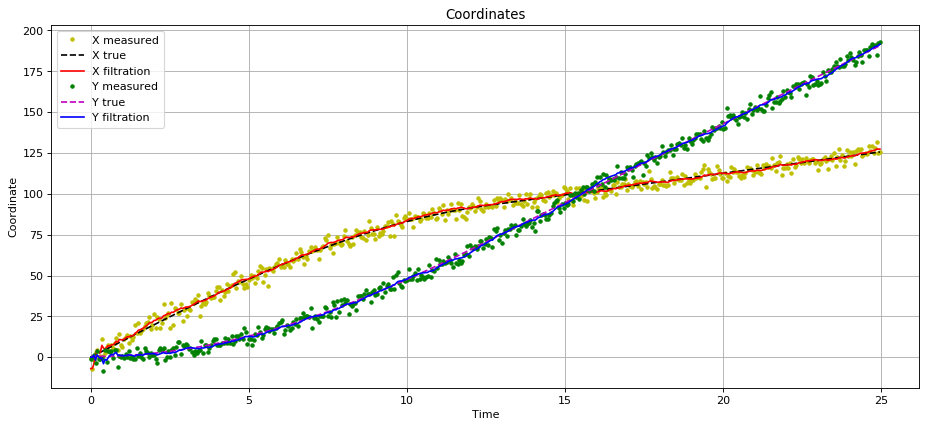

In [17]:
# Plot
plt.figure(figsize=(14, 6), dpi=80)
plt.plot(time, zx, "y.", label='X measured')
plt.plot(time, x, "k--", label='X true')
plt.plot(time, Xf[0], 'r-', label = "X filtration")
plt.plot(time, zy, "g.", label='Y measured')
plt.plot(time, y, "m--", label='Y true')
plt.plot(time, Xf[2], 'b-', label = "Y filtration")
plt.title('Coordinates')
plt.grid()
plt.xlabel('Time')
plt.ylabel('Coordinate')
plt.legend()
plt.show()

Run Linear Kalman filter on the basis of GPS data only over 𝑀=500 runs.  

In [18]:
# Errors
def errors_run(t, v):
    "returns errors of estimation e of variable v"
    return (t - v) ** 2

In [19]:
# M runs
M = 500
ErrorRunXf = []
ErrorRunXp = []
ErrorRunYf = []
ErrorRunYp = []
for i in range(M):
    [x,y] = generate_trajectory(N, T, x0, y0, V0, theta, sigma_a)
    [zx, zy] = generate_measurements(x, y, sigma_eta_x, sigma_eta_y)
    [Xf, Xp, Pf, Pp] = KalmanFilter(zx, zy, T, X0, P00, R, F, Q, H)
    ErrorRunXf.append(errors_run(x, Xf[0]))
    ErrorRunXp.append(errors_run(x, Xp[0]))
    ErrorRunYf.append(errors_run(y, Xf[2]))
    ErrorRunYp.append(errors_run(y, Xp[2]))

In [20]:
# Final Error Calculation
Final_Error_Xf = (np.sum(ErrorRunXf, axis=0) / (M - 1)) ** .5
Final_Error_Xp = (np.sum(ErrorRunXp, axis=0) / (M - 1)) ** .5
Final_Error_Yf = (np.sum(ErrorRunYf, axis=0) / (M - 1)) ** .5
Final_Error_Yp = (np.sum(ErrorRunYp, axis=0) / (M - 1)) ** .5

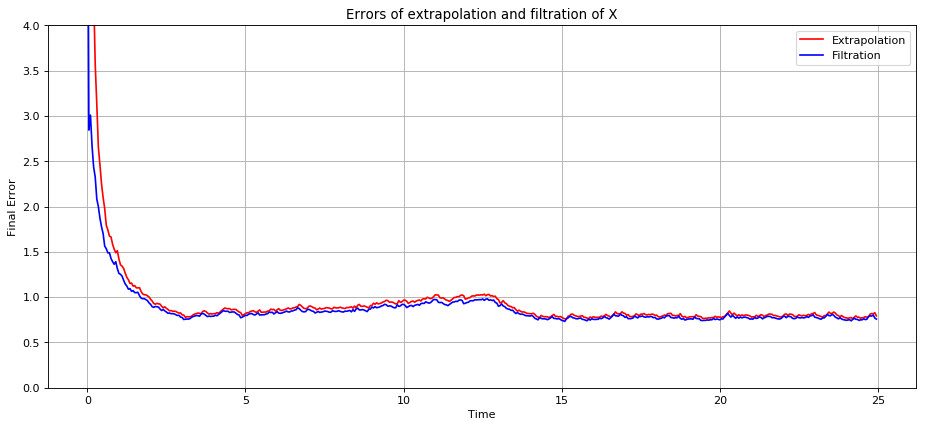

In [21]:
# Plot
plt.figure(figsize=(14, 6), dpi=80)
plt.plot(time, Final_Error_Xp, 'r-', label = "Extrapolation")
plt.plot(time, Final_Error_Xf, 'b-', label = "Filtration")

plt.grid()
plt.legend()
plt.title('Errors of extrapolation and filtration of X')
plt.xlabel('Time')
plt.ylabel('Final Error')
plt.ylim(0,4)
plt.show()

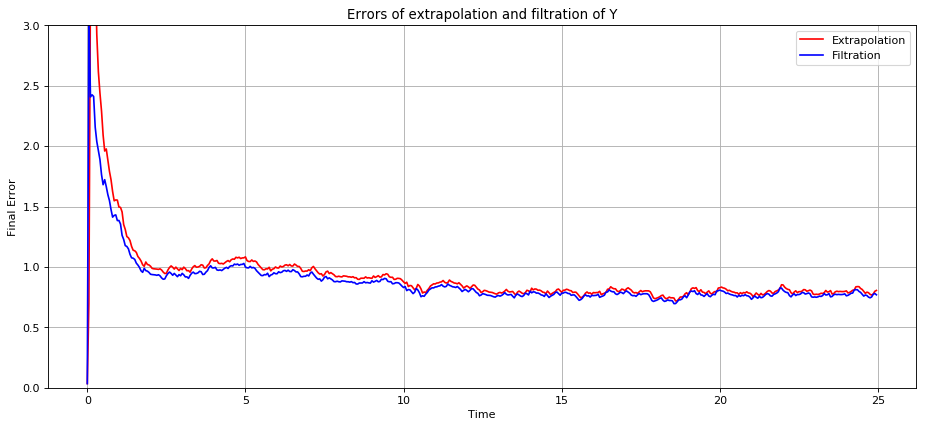

In [22]:
# Plot
plt.figure(figsize=(14, 6), dpi=80)
plt.plot(time, Final_Error_Yp, 'r-', label = "Extrapolation")
plt.plot(time, Final_Error_Yf, 'b-', label = "Filtration")

plt.grid()
plt.legend()
plt.title('Errors of extrapolation and filtration of Y')
plt.xlabel('Time')
plt.ylabel('Final Error')
plt.ylim(0,3)
plt.show()

## Part II. Assimilation of both GPS data (absolute positioning) and wheel odometry data (relative positioning). 

In [23]:
[x,y] = generate_trajectory(N, T, x0, y0, V0, theta, sigma_a)
[zx, zy] = generate_measurements(x, y, sigma_eta_x, sigma_eta_y)

Add odometry

In [24]:
def generate_measurements_V(N, V, sigma_eta_V):
    return (V*np.ones(N) + np.random.normal(0, sigma_eta_V, N))

In [25]:
sigma_eta_V = .5

In [26]:
Vm = generate_measurements_V(N, V0, sigma_eta_V)

In [27]:
def generate_measurements_theta(theta, sigma_eta_theta):
    return (theta + np.random.normal(0, sigma_eta_theta, theta.size))

In [28]:
sigma_eta_theta = .02

In [29]:
theta_m = generate_measurements_theta(theta, sigma_eta_theta)

### Extended Kalman Filter

In [30]:
R = np.diag([sigma_eta_x**2,sigma_eta_y**2,sigma_eta_V**2,sigma_eta_theta**2])

In [31]:
#initial cond.
X0 = np.array([[zx[1]], [(zx[1]-zx[0])/T], [zy[1]], [(zy[1]-zy[0])/T]])

In [32]:
def myarctan(Vx,Vy):
    if Vx>0:
        return np.arctan(Vy/Vx)
    if Vy>=0 and Vx<0:
        return np.arctan(Vy/Vx)+np.pi
    if Vy<0 and Vx<0:
        return np.arctan(Vy/Vx)-np.pi
    # Vx == 0
    if Vy>0:
        return np.pi/2
    return -np.pi/2

def h(X):
    x = X[0]
    Vx = X[1]
    y = X[2]
    Vy = X[3]
    return np.array([[x],[y],[(Vx**2+Vy**2)**.5], [myarctan(Vx,Vy)]])

def dh_d(X):
    Vx = X[1]
    Vy = X[3]
    VV = Vx**2+Vy**2
    V = VV**.5
    return np.array([[1,0,0,0],[0,0,1,0],[0,Vx/V,0,Vy/V],[0,-Vy/VV,0,Vx/VV]])

# Kalman Filter
def ExtendedKalmanFilter(zx, zy, Vm, theta_m, Xf0, P00, R, F, Q):
    N = zx.size
    z = np.array([zx, zy, Vm, theta_m])
    Xp = np.zeros((4,N))
    Xp[:,0] = Xf0[:,0]
    Xf = np.zeros((4,N))
    Xf[:,0] = Xf0[:,0]
    Ht = np.transpose(H)
    Ft = np.transpose(F)
    I = np.eye(4)
    K = np.zeros((4,4,N))
    Pp = np.zeros((4,4,N))
    Pp[:,:,0] = P00
    Pf = np.zeros((4,4,N))
    Pf[:,:,0] = P00
    for i in range(0,N-1):
        # prediction
        Xp[:,i+1] = np.matmul(F, Xf[:,i])
        Pp[:,:,i+1] = np.matmul(np.matmul(F, Pf[:,:,i]), Ft) + Q
        # filtration
        dhX_dX = dh_d(Xp[:,i+1])
        dhX_dX_T = np.transpose(dhX_dX)
        K[:,:,i+1] = np.matmul(Pp[:,:,i+1], np.matmul(dhX_dX_T, np.linalg.inv(np.matmul(np.matmul(dhX_dX, Pp[:,:,i+1]), dhX_dX_T) + R)))
        Xf[:,[i+1]] = Xp[:,[i+1]] + np.matmul(K[:,:,i+1], (z[:,[i+1]] - h(Xp[:,i+1])))
        Pf[:,:,i+1] = np.matmul(I - np.matmul(K[:,:,i+1], dhX_dX), Pp[:,:,i+1])
    return [Xf, Xp, Pf, Pp];

In [33]:
[x,y] = generate_trajectory(N, T, x0, y0, V0, theta, sigma_a)
[zx, zy] = generate_measurements(x, y, sigma_eta_x, sigma_eta_y)
X0 = np.array([[zx[1]], [(zx[1]-zx[0])/T], [zy[1]], [(zy[1]-zy[0])/T]])
[Xf2, Xp2, Pf2, Pp2] = ExtendedKalmanFilter(zx, zy, Vm, theta_m, X0, P00, R, F, Q)

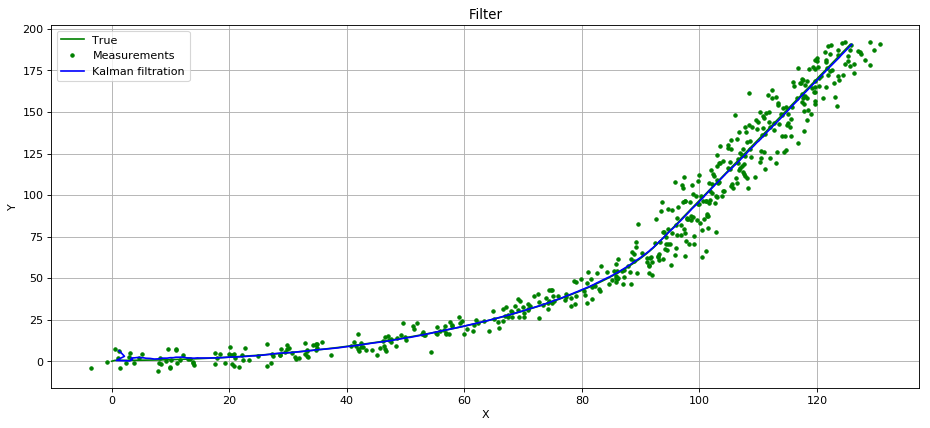

In [34]:
# Plot Kalman
plt.figure(figsize=(14, 6), dpi=80)
plt.plot(x, y, "g-", label='True')
plt.plot(zx, zy, "g.", label='Measurements')
plt.plot(Xf2[0], Xf2[2], 'b-', label = "Kalman filtration")

plt.grid()
plt.legend()
plt.title('Filter')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

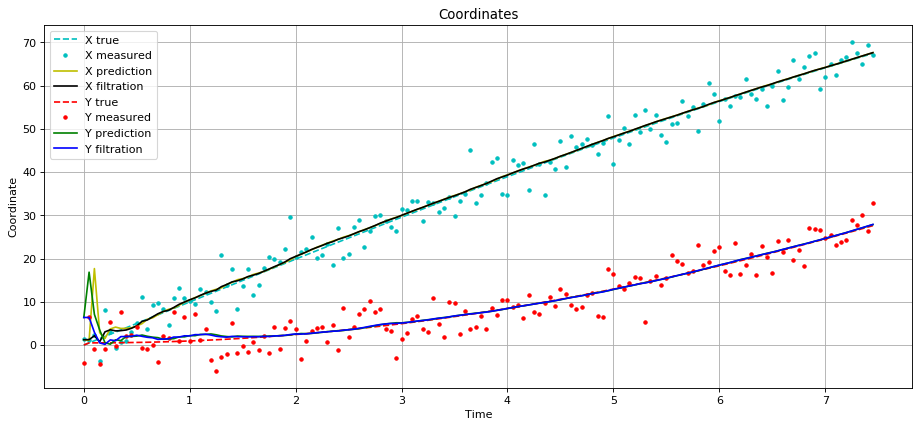

In [35]:
# Plot first l
l = 150
plt.figure(figsize=(14, 6), dpi=80)
plt.plot(time[:l], x[:l], "c--", label='X true')
plt.plot(time[:l], zx[:l], "c.", label='X measured')
plt.plot(time[:l], Xp2[0][:l], 'y-', label = "X prediction")
plt.plot(time[:l], Xf2[0][:l], 'k-', label = "X filtration")
plt.plot(time[:l], y[:l], "r--", label='Y true')
plt.plot(time[:l], zy[:l], "r.", label='Y measured')
plt.plot(time[:l], Xp2[2][:l], 'g-', label = "Y prediction")
plt.plot(time[:l], Xf2[2][:l], 'b-', label = "Y filtration")
#plt.plot(time, y, "g.", label='Y true')
#plt.plot(time, Xf2[2], 'b-', label = "Y filtration")
plt.title('Coordinates')
plt.grid()
plt.xlabel('Time')
plt.ylabel('Coordinate')
plt.legend()
plt.show()

Run Extended Kalman filter assimilating GPS data and odometry data over 𝑀=500 runs.

In [36]:
# M runs
M = 500
ErrorRunXf2 = []
ErrorRunXp2 = []
ErrorRunYf2 = []
ErrorRunYp2 = []
for i in range(M):
    [x,y] = generate_trajectory(N, T, x0, y0, V0, theta, sigma_a)
    [zx, zy] = generate_measurements(x, y, sigma_eta_x, sigma_eta_y)
    X0 = np.array([[zx[1]], [(zx[1]-zx[0])/T], [zy[1]], [(zy[1]-zy[0])/T]])
    [Xf2, Xp2, Pf2, Pp2] = ExtendedKalmanFilter(zx, zy, Vm, theta_m, X0, P00, R, F, Q)
    ErrorRunXf2.append(errors_run(x, Xf2[0]))
    ErrorRunXp2.append(errors_run(x, Xp2[0]))
    ErrorRunYf2.append(errors_run(y, Xf2[2]))
    ErrorRunYp2.append(errors_run(y, Xp2[2]))

In [37]:
# Final Error Calculation
Final_Error_Xf2 = (np.sum(ErrorRunXf2, axis=0) / (M - 1)) ** .5
Final_Error_Xp2 = (np.sum(ErrorRunXp2, axis=0) / (M - 1)) ** .5
Final_Error_Yf2 = (np.sum(ErrorRunYf2, axis=0) / (M - 1)) ** .5
Final_Error_Yp2 = (np.sum(ErrorRunYp2, axis=0) / (M - 1)) ** .5

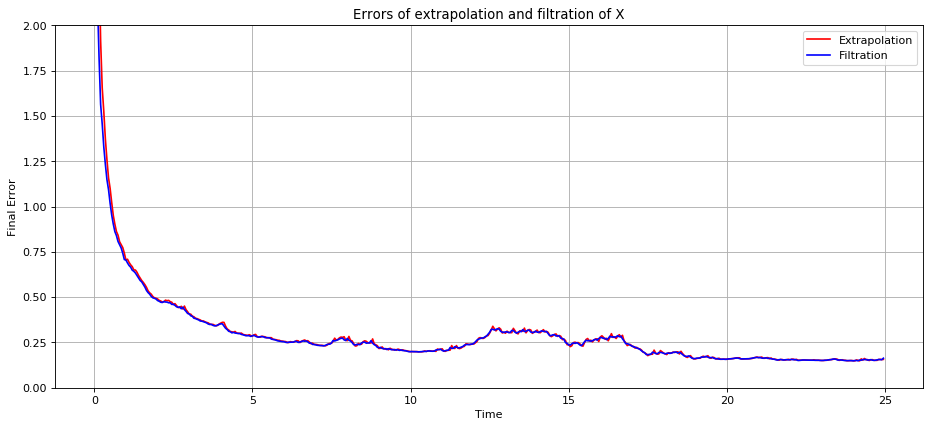

In [38]:
# Plot
plt.figure(figsize=(14, 6), dpi=80)
plt.plot(time, Final_Error_Xp2, 'r-', label = "Extrapolation")
plt.plot(time, Final_Error_Xf2, 'b-', label = "Filtration")

plt.grid()
plt.legend()
plt.title('Errors of extrapolation and filtration of X')
plt.xlabel('Time')
plt.ylabel('Final Error')
plt.ylim(0,2)
plt.show()

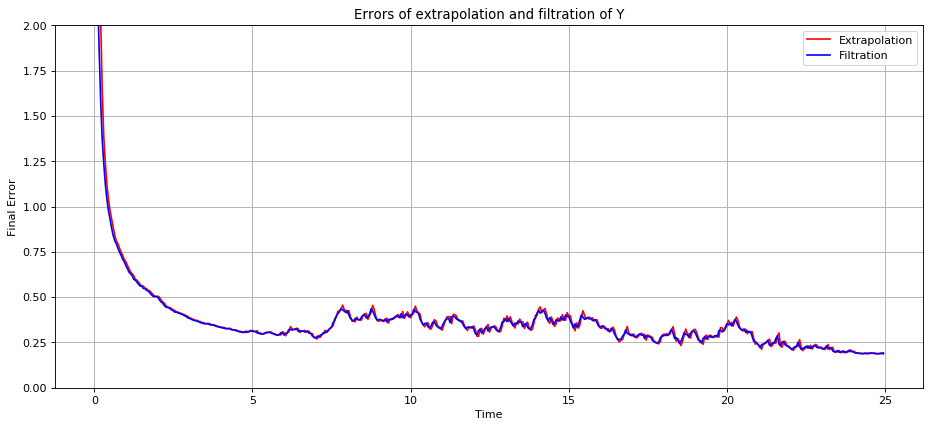

In [39]:
# Plot
plt.figure(figsize=(14, 6), dpi=80)
plt.plot(time, Final_Error_Yp2, 'r-', label = "Extrapolation")
plt.plot(time, Final_Error_Yf2, 'b-', label = "Filtration")

plt.grid()
plt.legend()
plt.title('Errors of extrapolation and filtration of Y')
plt.xlabel('Time')
plt.ylabel('Final Error')
plt.ylim(0,2)
plt.show()

For estimation of coordinates extra data (odometry) improved the final error from 0.7-0.8 to 0.2-0.3 (approximately). This is a great improvemets in quality of trecking the vehicle.

## Conclusion
A tracking filter for estimating vehicle’s dynamic state by assimilating the navigation data coming from different sources was developed. GPS data (absolute positioning) and wheel odometry data (relative positioning) can be fused in Extended Kalman Filter to get accurate estimations. This can be used for intelligent traffic applications.
Fused data can give much more accurate estimations. In this particular case, accurasy improved around 3-fold.